In [5]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
from auxillary.yolo_code_that_we_use import *
from tqdm.notebook import tqdm
from auxillary.confusion_matrix_class import ConfusionMatrix

from auxillary.mapping import HomographyMapping
#from AUC
from auxillary.detection import get_label,compare_post_process,table_analysis,load_dataset,set_im_and_label_paths_to_all
#from main
from auxillary.detection import load_detection_model,get_detection,helper_plot_bbox,plot_bboxes

import json
from roboflow import Roboflow
from pathlib import Path

from auxillary.RL_usedirectly import load_RL_no_env

%matplotlib inline

In [2]:
# IMPORT CHANGES WITHOUT RESTARTING KERNEL

import importlib
import auxillary.mapping
importlib.reload(auxillary.mapping)
from auxillary.mapping import HomographyMapping

### Do Everything in One Go for quick testing

In [3]:
dataset_name = Path('8-Ball-Pool-3')

model_path = 'detection_model_weight/detection_model.pt'
detection_model = load_detection_model(model_path)

RL_model_path = 'RL_models/PPO.zip'
RL_model = load_RL_no_env(RL_model_path)

Using cache found in C:\Users\jonas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-12 Python-3.11.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


C:\Users\jonas/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:907: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Error in dot count, using only corners for mapping


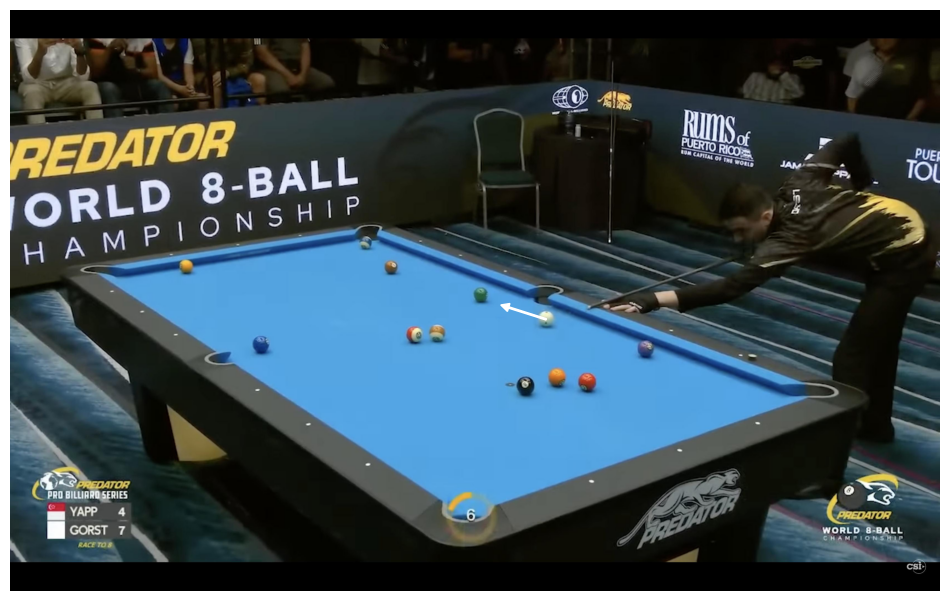

In [4]:
# do everything at once for testing quickly
%matplotlib inline

imagenum = 1 # index of the image to use
datanum = 1  # index of the data to use, if multiple images are available for the same imagenum

save_folder = Path('plot_export/') / str(imagenum)
save_folder.mkdir(parents=True, exist_ok=True)

im_paths, _ = load_dataset(dataset_name, imagenum=imagenum)

image, detections = get_detection(im_path=im_paths[datanum], model=detection_model, post_process=True)
Object = HomographyMapping(detections=detections,
                           im=image,
                           savepath=save_folder)
Object.RL_predict(RL_model)
Object.plot_RL_arrow(save=False,plot_warped=False)

### Load dataset from Roboflow

In [6]:
dataset_name = Path('8-Ball-Pool-3')
# folder_type = 'train'
weight_path = Path('detection_model_weight/detection_model.pt')

if not dataset_name.exists():
    with open("roboflow.json", "r") as f:
        roboflow_api_key = json.load(f)
    rf = Roboflow(api_key=roboflow_api_key["ROBOFLOW_API_KEY"])
    project = rf.workspace("bachelorthesis").project("8-ball-pool-l530o")
    project.version(3).download("yolov5");

### Main

Load model and get detection from images in a folder. These will function as the states for the RL environment.

In [7]:
imagenum = 1 # index of the image to use
datanum = 1  # index of the data to use, if multiple images are available for the same imagenum

save_folder = Path('plot_export/') / str(imagenum)
save_folder.mkdir(parents=True, exist_ok=True)

im_paths, label_paths = load_dataset(dataset_name, imagenum=imagenum)

im_path = im_paths[datanum]
label_path = label_paths[datanum]
if len(im_paths) > 1: 
    print('Doublecam available:',[i.name.split('_')[0] for i in im_paths])
    doublecam=True
else:
    doublecam=False
    print('Doublecam not available')

print('image used: ',im_path.name)
print('labels used:', label_path.name)

# to use your own image, simply set the im_path and label_path to a custom path

Doublecam available: ['1', '1a', '1t']
image used:  1a_png.rf.17bf9820312efff2213b1d1b08ffad66.jpg
labels used: 1a_png.rf.17bf9820312efff2213b1d1b08ffad66.txt


In [8]:
model_path = 'detection_model_weight/detection_model.pt'
detection_model = load_detection_model(model_path)

Using cache found in C:\Users\jonas/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-5-12 Python-3.11.9 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


saved to plot_export\1\plot_bboxes.png


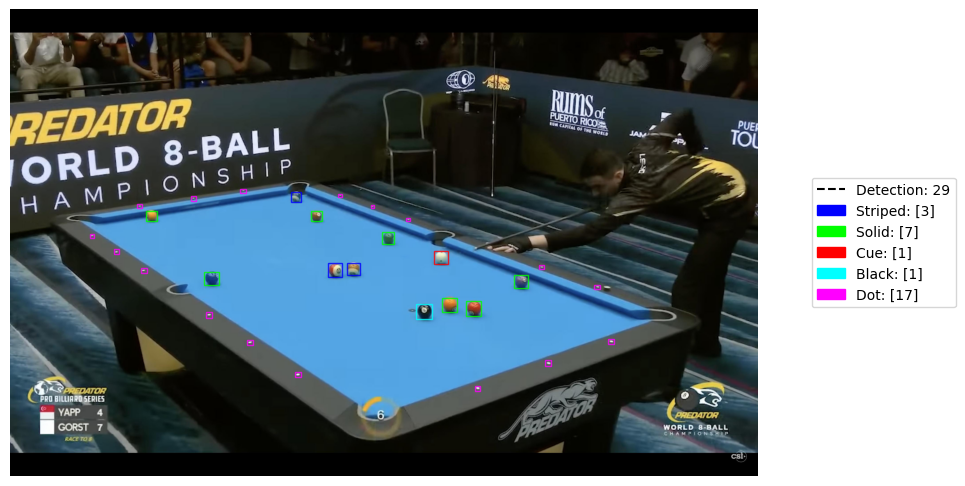

In [9]:
%matplotlib inline

image, detections = get_detection(im_path=im_path, model=detection_model, post_process=True)

if False: # Plot post processing comparison
    # TODO change to accomodate center format
    truelabels = get_label(label_path, image.shape[:2])
    image_before, detections_before = get_detection(im_path=im_path, model=detection_model, post_process=False)
    compare_post_process(image, truelabels, detections_before, detections,
                         save_path=save_folder / 'compare_post_process.png')

if True: # Plot bounding boxes for the specific image
    plot_bboxes(image, None, detections,
                save_path=save_folder / f'plot_bboxes.png')


Error in dot count, using only corners for mapping


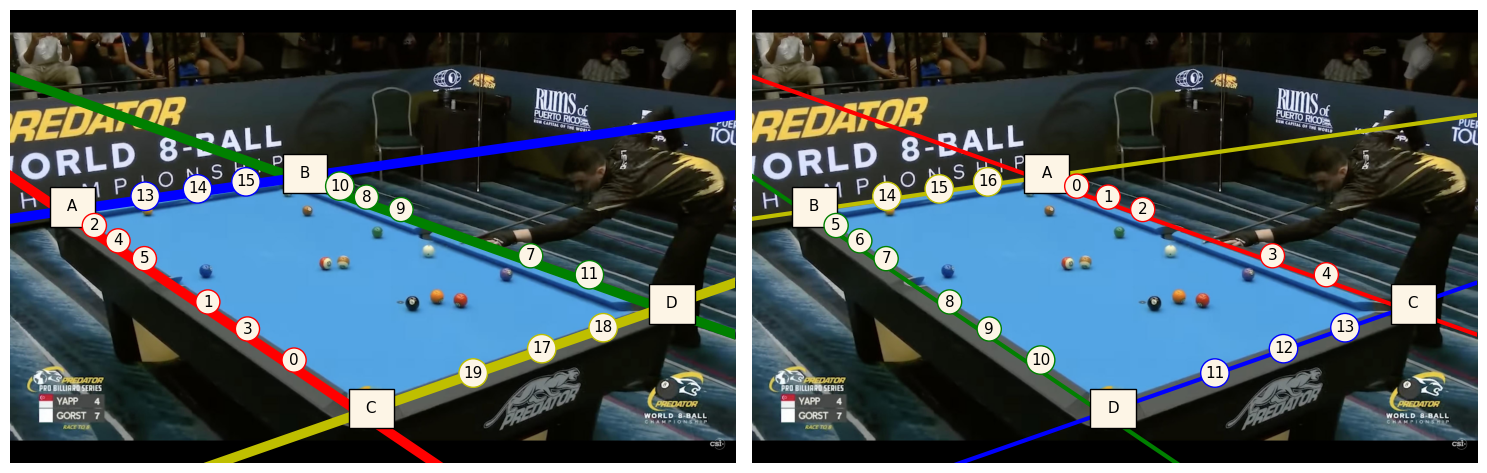

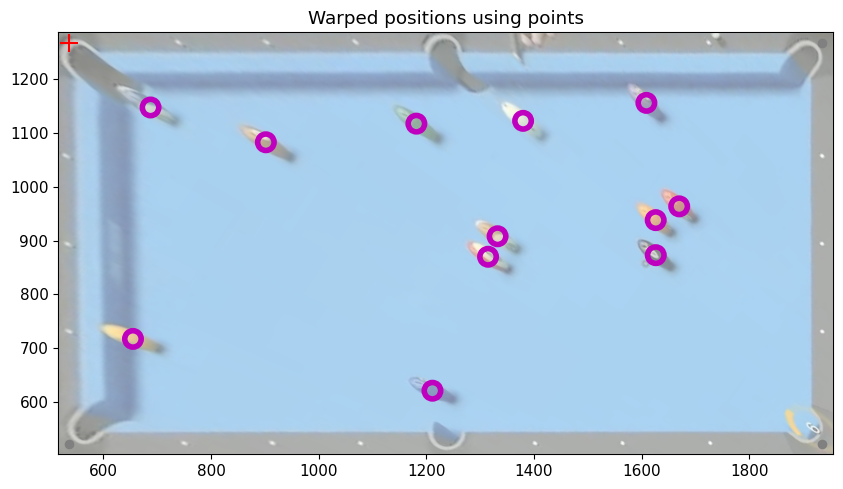

In [10]:
%matplotlib inline
# Use HomographyMapping to extract lines and convert to RL environment format

# TODO: check angleratio use
Object = HomographyMapping(detections=detections,
                           im=image,
                           savepath=save_folder)

Object.plot_lines(save=True)

# Object.plot_template(save=True)

Object.plot_warped()


`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Error in dot count, using only corners for mapping


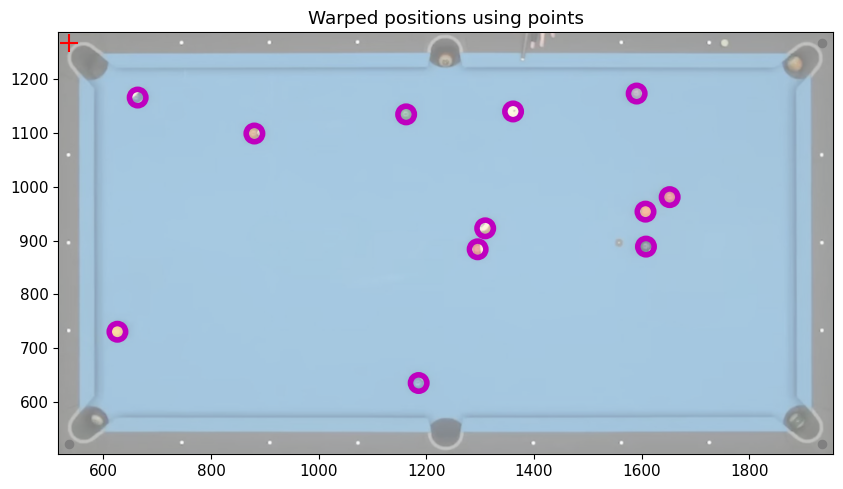

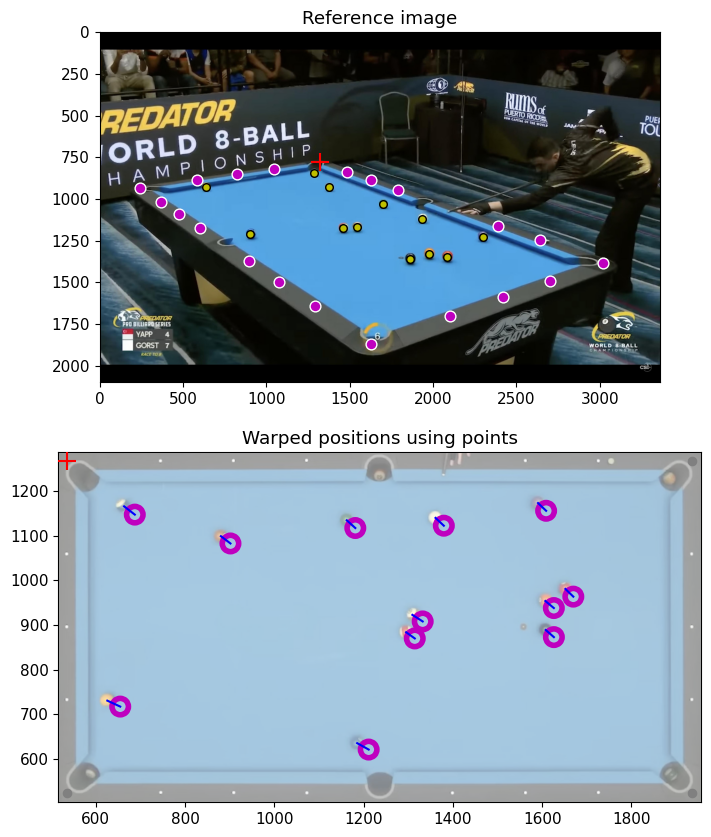

In [11]:
# compare image 1 to topview (image 2)
if doublecam:
    datanum_compare = datanum + 1
    im_path_compare = im_paths[datanum_compare]
    label_path_compare = label_paths[datanum_compare]

    image_compare, detections_compare = get_detection(im_path=im_path_compare, model=detection_model, post_process=True)

    # plot_bboxes(image_compare, None, detections_compare,
    #             save_path=save_folder / f'plot_bboxes.png')
    
    Object_compare = HomographyMapping(detections=detections_compare,
                                       im=image_compare,
                                       savepath=save_folder)

    # r = radius from pocket center to remove pocketed balls
    mask = Object_compare.remove_pocketed_balls(r=100)

    Object_compare.plot_warped()

    Object.plot_compare2topview(Object_compare)

### Combine RL with images

In [12]:
RL_model_path = 'RL_models/PPO.zip'
RL_model = load_RL_no_env(RL_model_path)

In [13]:
Object.RL_predict(RL_model)

array([    -99.343,     -11.442])

### POOL ENV

In [14]:
import gymnasium as gym

from auxillary.RL_Pool_env3 import PoolEnv
from auxillary.RL_config_env import *
from auxillary.RL_functions import run_model, load_RL_model

from auxillary.RL_custom_evaluate_policy import custom_evaluate_policy
from auxillary.RL_custom_evaluate_policy import custom_evaluate_policy_masked

from stable_baselines3 import PPO, TD3, A2C, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env

from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

In [18]:
# Setup
ALGO = "PPO"  # PPO_masked  TD3  PPO  SAC DDPG A2C
ORACLE = False  # Enable Oracle if true
nb = 16  # Number of balls.
max_num_shots = 10  # Number of shots before a state resets if no game ending criteria has been met

# Load learned states
assert nb == 1 or nb == 2 or nb == 16
if nb == 2: ls = np.load("1_000_000_states.npy")
elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
else: ls = None

# ls = np.load('rl_balls.npy')
ls = Object.to_RL()
# Try with image above
# ls = detections[detections[:, -1] != 4][:, [0, 1, -1]]  # Get only ball detections and keep only x,y and class values

env_kwargs = dict(
    algo=ALGO,
    balls_init=ls,
    suit=2,
    training=False,
    fps=60,  # 60
    num_balls=nb,
    special_state=None,  # 497852  666
    obs_type='vector',
    sigma=0,
    oracle=ORACLE,
    game_type='normal',  # 'blue_only' or 'normal'
    bank_shots=False,
    max_num_shots=10
)

use_masking = True if ALGO == 'PPO_masked' else False

In [68]:
RL_model, env = load_RL_model(ALGO, env_kwargs)
run_model(RL_model, env, max_steps=100, render=True, use_masking=use_masking)

Using PPO algorithm
------------------------------
Pressed SPACE
CALLED: close()


SystemExit: 

### Oracle

In [26]:
from pymunk.vec2d import Vec2d
state = Object.to_RL()
state

array([[    0.46105,     0.79883,           2],
       [    0.48241,     0.13186,           2],
       [     0.7787,     0.55788,           2],
       [    0.80987,     0.59228,           2],
       [    0.60268,     0.80582,           3],
       [    0.77877,     0.47035,           4],
       [    0.76634,     0.85071,           2],
       [    0.26131,     0.75233,           2],
       [   0.084931,     0.26123,           2],
       [    0.56885,     0.51756,           1],
       [    0.55619,     0.46639,           1],
       [    0.10825,     0.83921,           1]])

In [44]:
test_state = state[:, :]
test_cue = test_state[test_state[:, -1] == 3].flatten()[:2]
print(len(test_cue))
# test_cue = Vec2d(*test_cue)

# test_cue

2


In [ ]:
def add_ghosts(state):
    ghosts = []
    
    for ball in state:
        real_ball_pos = ball[:2]
        
        for i, line in enumerate([0.0, 1.0, 0.0, 1.0]):  # min_x, max_x, min_y, max_y
            dist = real_ball_pos[int(i>=2)] - line
            if dist > BALL_RADIUS or dist < -BALL_RADIUS:
                if i < 2:   coord = (line-dist,real_ball_pos[1])
                else:       coord = (real_ball_pos[0],line-dist)

                if ball[2] != 3: ghosts.append(coord)  # If ball is not cue ball, add its ghost version
    return ghosts


# TODO: Complete this function
def get_pocket_targets():
    pockets = np.array([[0.0, 0.0],  # left-bot
                        [1.0, 0.0],  # right-bot
                        [1.0, 1.0],  # right-top
                        [0.0, 1.0],  # left-top
                        [0.5, 1.0],  # mid-top
                        [0.5, 0.0]   # mid-bot
                        ])

    extra_targets = []

    for i, line in enumerate([0.0, 1.0, 0.0, 1.0]):  # min_x, max_x, min_y, max_y
        for k,target in enumerate(pockets):
            dist = target[int(i>=2)] - line
            dist1 = CUSHION_CORNERS[k][0][int(i>=2)] - line
            dist2 = CUSHION_CORNERS[k][1][int(i>=2)] - line
            if dist > POCKET_RADIUS or dist < -POCKET_RADIUS:
                self.pocket_ids.append(100*(i+1) + k)
                if i < 2:
                    extra_targets.append([line-dist,target[1]])
                    extra_corners.append([[line-dist1,CUSHION_CORNERS[k][0][1]],[line-dist2,CUSHION_CORNERS[k][1][1]]])
                else:
                    extra_targets.append([target[0],line-dist])
                    extra_corners.append([[CUSHION_CORNERS[k][0][0],line-dist1],[CUSHION_CORNERS[k][1][0],line-dist2]])


    self.target_points = np.concatenate([TARGET_POSITIONS,extra_targets])

In [70]:
CUSHION_POSITIONS

[((59.0, 97.0), (81.0, 125.0), (81.0, 695.0), (59.0, 723.0)),
 ((1411.0, 723.0), (1389.0, 695.0), (1389.0, 125.0), (1411.0, 97.0)),
 ((1373.0, 761.0), (1345.0, 739.0), (774.0, 739.0), (767.0, 761.0)),
 ((703.0, 761.0), (696.0, 739.0), (125.0, 739.0), (97.0, 761.0)),
 ((1373.0, 59.0), (1345.0, 81.0), (774.0, 81.0), (767.0, 59.0)),
 ((703.0, 59.0), (696.0, 81.0), (125.0, 81.0), (97.0, 59.0))]

In [69]:
b

array([[         81,         125],
       [         81,         695],
       [       1389,         695],
       [       1389,         125],
       [       1345,         739],
       [        774,         739],
       [        696,         739],
       [        125,         739],
       [       1345,          81],
       [        774,          81],
       [        696,          81],
       [        125,          81]])

In [ ]:
def find_best_shot(state, suit=2):
    # Find lines from balls to pockets
    good_vectors = []
    all_vectors = []

    best_shot = None
    hit_points = []
    good_hit_points = []
    
    pockets = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],  # bottom line pockets
                        [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]   # upper line pockets
                        ])
    cue_pos = state[state[:, -1] == 3].flatten()[:2]
    assert len(cue_pos) > 0, "No cue ball found."
    
    cue_pos = Vec2d(cue_pos)

    if len(state) == 1:  # There is only the cue ball
        random_int = np.random.randint(0, 6)
        pocket_pos = Vec2d(*pockets[random_int])
        best_shot = pocket_pos - cue_pos
        return np.array([best_shot.angle_degrees, 1.0])  # angle, force
    
    ghost_balls = add_ghosts()

    for ball in state:
        real_ball_pos = ball[:2]

        if ball[2] != suit:  # Only consider your own suit from here
            continue
        
        # TODO: Get target points
        for ghostnum, ball_pos in enumerate([real_ball_pos] + ghost_balls):
            # Find good pockets
            for i, pocket in enumerate(self.target_points):
                pocket_pos = Vec2d(*pocket)

                # Calculate pos the cue should hit
                pocket_vec = (pocket_pos - ball_pos).normalized()
                hit_pos = ball_pos - ((2 - 0) * BALL_RADIUS * pocket_vec)

                cue2hit_vector = (hit_pos - cue_pos).normalized()
                theta = cue2hit_vector.get_angle_degrees_between(pocket_vec)

                self.hit_points.append([Vec2d(*hit_pos), theta])  # Feasible hit_points
                all_vectors.append([hit_pos - cue_pos, i, ghostnum*100 + ball.number])
                if (theta > THETA_LIMIT) or (theta < -THETA_LIMIT):  # Bad pocket
                    continue


                # Check if there exists a line from ball to pocket
                if self.is_straight_line(ball_pos, pocket_pos,include=[hit_pos]):

                    # Check if there exists a line from cue to hit
                    if self.is_straight_line(cue_pos, hit_pos, exclude=[ball_pos]):

                        self.good_hit_points.append(Vec2d(*hit_pos))
                        self.draw_stuff["hit_points"].append(hit_pos)
                        self.draw_stuff["hit_points_details"].append([ball_pos,pocket_pos])
                        self.good_vectors.append([hit_pos - cue_pos, i, ghostnum*100 + ball.number])

    # ball for loop end
    if len(self.good_vectors) != 0:
        self.best_shot, best, self.best_score = self.best_shot_criteria(self.good_vectors)
        self.draw_stuff["hit_points_best"] = self.draw_stuff["hit_points"][best]
        self.draw_stuff["draw_hit_points"] = True

    else:
        self.best_shot, best, self.best_score = self.best_shot_criteria(all_vectors)
    return None

In [ ]:


def best_shot_criteria(self, best_vectors):
    hit_vectors, pocket_id, ball_number = zip(*best_vectors)
    scores = []
    self.scores = []

    for i in range(len(best_vectors)):

        b_id = ball_number[i] // 100
        p_id = self.pocket_ids[pocket_id[i]] // 100

        if b_id == 0 and p_id == 0:     # both in main table
            multiplier = 1
        elif b_id == p_id:              # cue cushion hit
            multiplier = 3/4
        elif b_id == 0 and p_id != 0:   # blue cushion hit
            multiplier = 1/2
        else:                           # different tables
            multiplier = 1/4

        cus1 = Vec2d(*self.cushion_corners[pocket_id[i]][0])
        cus2 = Vec2d(*self.cushion_corners[pocket_id[i]][1])

        if ball_number[i] < 100:
            ballpos = self.balls[ball_number[i]].body.position
        else:
            ballpos = self.ghost_balls[(ball_number[i] // 100) - 1]
        a1 = cus1 - ballpos
        a2 = cus2 - ballpos

        angle_between = abs(a1.get_angle_degrees_between(a2)) / 60

        # window
        self.window_vectors.append((ballpos,cus1,cus2,angle_between,pocket_id[i]))

        # Cosine_sim weight
        hit_vec = hit_vectors[i].normalized()
        poc_vec = (Vec2d(*self.target_points[pocket_id[i]]) - ballpos).normalized()

        cos_weight = hit_vec.dot(poc_vec)

        scores.append((angle_between + cos_weight) * multiplier)
        self.scores.append([angle_between,cos_weight,multiplier, scores[-1]])

    best = np.argmax(scores)
    bestscore = np.max(scores)
    return hit_vectors[best], best, bestscore

def is_straight_line(self, main_pos, target_pos, exclude=[], include=[]):
    # Checks if there is an unobstructed line from main_pos to target_pos.
    # Main_pos: Vec2d
    # Target_pos: Vec2d
    # exclude: [Vec2d, Vec2d]   -- list of points to exclude other than main and target

    main_pos = Vec2d(*main_pos)
    target_pos = Vec2d(*target_pos)

    def point_on_line_seg(a, b, p):
        # a is start of line segment
        # b is end of line segment
        # p is point we want to find the distance to
        a = Vec2d(*a)
        b = Vec2d(*b)
        p = Vec2d(*p)
        ap = p - a
        ab = b - a

        t = ap.dot(ab) / ab.get_length_sqrd()
        # if you need the the closest point belonging to the segment
        t = max(0, min(1, t))
        point = a + (t * ab)
        dist = p.get_distance(point)
        return dist

    def hits(item, exlist,s,r=2):
        try: 
            [ball.body.position for ball in item]
        except:
            pos = np.array([Vec2d(*position) for position in item
                                    if Vec2d(*position) not in exlist]).reshape(-1, 2)
        else:
            pos = np.array([ball.body.position for ball in item 
                                    if ball.body.position not in exlist]).reshape(-1, 2)
        
        dists = [point_on_line_seg(exlist[0], exlist[1], ball) for ball in pos]
        hit = sum([abs(d) <= (r * BALL_RADIUS) for d in dists]) > 0
        return hit

    exlist = [main_pos, target_pos] + exclude        
    
    if hits(self.balls, exlist,"bal"):
        self.trash_lines.append([main_pos,target_pos,"ball"])
        return False
        
    elif hits(self.ghost_balls, exlist,"gho"):
        self.trash_lines.append([main_pos,target_pos,"ghost"])
        return False
        
    elif hits(self.ghost_opponents, exlist,"opp"):
        self.trash_lines.append([main_pos,target_pos,"ghost_opp"])
        return False
        
    elif hits(self.target_points, exlist,"poc"):
        self.trash_lines.append([main_pos,target_pos,"pocket"])
        return False

    return True  # The line has no obstructions
    

def add_ghosts(self):
    self.ghost_balls = []
    self.ghost_opponents = []
    
    for ball in self.balls:
        real_ball_pos = ball.body.position

        ghosts = []
        ghost_opponents = []
        if self.bank_shots:
            for i, line in enumerate(CUSHION_INNER_LINES):
                dist = real_ball_pos[int(i>=2)] - line
                if dist > BALL_RADIUS or dist < -BALL_RADIUS:
                    if i < 2:   coord = (line-dist,real_ball_pos[1])
                    else:       coord = (real_ball_pos[0],line-dist)

                    if ball.ballclass == self.suit: ghosts.append(coord)
                    elif ball.ballclass != self.cue_ball.ballclass: ghost_opponents.append(coord)

        self.ghost_balls = self.ghost_balls + ghosts
        self.ghost_opponents = self.ghost_opponents + ghost_opponents
    

def find_best_shot(self):
    # Find lines from balls to pockets
    self.good_vectors = []
    all_vectors = []
    self.draw_stuff["hit_points"] = []
    self.draw_stuff["hit_points_details"] = []
    self.best_shot = None
    self.hit_points = []
    self.good_hit_points = []

    cue_pos = self.cue_ball.body.position

    if self.num_balls == 1:
        random_int = np.random.randint(0, 6)
        pocket_pos = Vec2d(*self.target_points[random_int])
        self.best_shot = pocket_pos - cue_pos
        return None
    
    self.add_ghosts()

    for ball in self.balls:
        real_ball_pos = ball.body.position

        if ball.ballclass != self.suit:  # Only consider your own suit from here
            continue
        
        for ghostnum, ball_pos in enumerate([real_ball_pos] + self.ghost_balls):
            # Find good pockets
            for i, pocket in enumerate(self.target_points):
                pocket_pos = Vec2d(*pocket)

                # Calculate pos the cue should hit
                pocket_vec = (pocket_pos - ball_pos).normalized()
                hit_pos = ball_pos - ((2 - 0) * BALL_RADIUS * pocket_vec)

                cue2hit_vector = (hit_pos - cue_pos).normalized()
                theta = cue2hit_vector.get_angle_degrees_between(pocket_vec)

                self.hit_points.append([Vec2d(*hit_pos), theta])  # Feasible hit_points
                all_vectors.append([hit_pos - cue_pos, i, ghostnum*100 + ball.number])
                if (theta > THETA_LIMIT) or (theta < -THETA_LIMIT):  # Bad pocket
                    continue


                # Check if there exists a line from ball to pocket
                if self.is_straight_line(ball_pos, pocket_pos,include=[hit_pos]):

                    # Check if there exists a line from cue to hit
                    if self.is_straight_line(cue_pos, hit_pos, exclude=[ball_pos]):

                        self.good_hit_points.append(Vec2d(*hit_pos))
                        self.draw_stuff["hit_points"].append(hit_pos)
                        self.draw_stuff["hit_points_details"].append([ball_pos,pocket_pos])
                        self.good_vectors.append([hit_pos - cue_pos, i, ghostnum*100 + ball.number])

    # ball for loop end
    if len(self.good_vectors) != 0:
        self.best_shot, best, self.best_score = self.best_shot_criteria(self.good_vectors)
        self.draw_stuff["hit_points_best"] = self.draw_stuff["hit_points"][best]
        self.draw_stuff["draw_hit_points"] = True

    else:
        self.best_shot, best, self.best_score = self.best_shot_criteria(all_vectors)
    return None

#### Ignore

In [21]:
def mask_fn(env: gym.Env) -> np.ndarray:
    # Do whatever you'd like in this function to return the action mask
    # for the current env. In this example, we assume the env has a
    # helpful method we can rely on.
    return env.valid_action_mask()


if __name__ == "__main__":
    # Settings
    obs_type = "vector"
    LOG = False
    TRAINING = False
    CHEAT = False
    timesteps = 1_200_000
    n_envs = 1

    # save_path = 'final_tests'
    nb = 16
    ALGO = "PPO_masked"  # PPO_masked  TD3  PPO  SAC DDPG A2C
    LOAD_MODEL = True

    assert nb == 1 or nb == 2 or nb == 16
    if nb == 2: ls = np.load("1_000_000_states.npy")
    elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
    else: ls = None
    
    env_kwargs = dict(
        algo=ALGO,
        balls_init=ls,
        suit=2,
        training=TRAINING,
        fps=60,  # 60
        num_balls=nb,
        special_state=None,  # 497852  666
        obs_type=obs_type,
        sigma=0,
        cheat_force=CHEAT,
        cheat_angle=CHEAT,
        game_type='normal',  # 'blue_only' or 'normal'
        bank_shots=False
    )
    env = make_vec_env(PoolEnv, seed=1, n_envs=n_envs, env_kwargs=env_kwargs)
    print(f"LOAD_MODEL: {LOAD_MODEL}")
    if ALGO != "PPO_masked":
        model_path = f"RL_models/{ALGO}.zip"
        if ALGO == "PPO":
            if LOAD_MODEL: model = PPO.load(model_path, env)
            else: model = PPO(policy='MlpPolicy', env=env)
        elif ALGO == "TD3":
            if LOAD_MODEL: model = TD3.load(model_path, env)
            else: model = TD3(policy='MlpPolicy', env=env)
        elif ALGO == "A2C":
            if LOAD_MODEL: model = A2C.load(model_path, env)
            else: model = A2C(policy='MlpPolicy', env=env)
        elif ALGO == "SAC":
            if LOAD_MODEL: model = SAC.load(model_path, env=env)
            else: model = SAC(model_path, env)
        elif ALGO == "DDPG":
            if LOAD_MODEL: model = DDPG.load(model_path, env=env)
            else: model = DDPG(model_path, env)

        # results = run_model(model, env, 1000, render=False)
        mean_reward, std_reward, sr, er = custom_evaluate_policy(
            model, env, n_eval_episodes=500, warn=False)

    else:
        env = PoolEnv(**env_kwargs)         # Initialize environment
        env = ActionMasker(env, mask_fn)    # Wrap to enable masking

        # policy_kwargs = dict(activation_fn=torch.nn.ReLU,
        #                      net_arch=dict(pi=[400, 300], vf=[400, 300]))

        model_kwargs = dict(
            policy=MaskableActorCriticPolicy,
            env=env,
            batch_size=256,
            # learning_rate=lr_schedule_linear(3e-4),
            # policy_kwargs=policy_kwargs,
            n_steps=2048,
            verbose=1
            # device='cuda'
        )

        model_path = f"RL_models/{ALGO}.zip"
        model2 = MaskablePPO.load(model_path, env)

        mean_reward, std_reward, sr, er = custom_evaluate_policy_masked(
            model2, env, n_eval_episodes=500, warn=False)


Using PPO_masked algorithm
------------------------------
LOAD_MODEL: True
Using PPO_masked algorithm
------------------------------
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.



--------------------------------------------------
Action                    Angle:  171.92
                          Force:  314.14

- reward off
pocketed_suit             50.00 with spec: ball 12 
first_hit_none            -7.36 with spec:  0.15 
- reward off
target_angle_pocket       41.58 with spec:  0.92 
--------------------------------------------------
Total Reward              84.22
Total Reward (normalized):     0.4011
--------------------------------------------------




--------------------------------------------------
Action                    Angle: -102.15
                          Force:  381.72

- reward off
- reward off
hit_suit                  10.00 
- reward off
target_angle_pocket       7.33 with spec:  7.44 
--------------------------------------------

SystemExit: 